# Advanced PM: Full Pipeline

This notebook combines all the components from previous tutorials into a production-quality simulation pipeline:
- PM N-body integration with **PGD correction** for small-scale sharpening
- **OnionTiler** for artifact-free full-sky spherical maps
- Multi-shell lightcone with angular power spectrum validation

This is the configuration you would use for a real analysis before applying lensing (covered in notebook 07).

## Setup

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.97"

import jax_fli as jfli
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

assert (
    jax.device_count() == 4
), "This notebook is designed to run on 4 devices for demonstration purposes. Please adjust the code if you have a different number of devices."

jax.config.update("jax_enable_x64", False)

print(f"Number of devices: {jax.device_count()}")
print(f"Devices {jax.devices()}")
jax.print_environment_info()

/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/compiler.py:783: UserWarning: Error reading persistent compilation cache entry for 'jit_convert_element_type': PermissionError: [Errno 13] Permission denied: '/jax_cache'
  warnings.warn(


Number of devices: 4
Devices [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
jax:    0.9.0.1
jaxlib: 0.9.0.1
numpy:  2.4.2
python: 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
device info: NVIDIA H100 80GB HBM3-4, 4 local devices"
process_count: 1
platform: uname_result(system='Linux', node='jzxh015', release='5.14.0-570.58.1.el9_6.x86_64', version='#1 SMP PREEMPT_DYNAMIC Tue Oct 21 04:15:07 EDT 2025', machine='x86_64')
JAX_PERSISTENT_CACHE_ENABLE_XLA_CACHES=xla_gpu_per_fusion_autotune_cache_dir
JAX_PERSISTENT_CACHE_MIN_ENTRY_SIZE_BYTES=-1
JAX_COMPILATION_CACHE_DIR=/jax_cache
JAX_PERSISTENT_CACHE_MIN_COMPILE_TIME_SECS=0
XLA_PYTHON_CLIENT_MEM_FRACTION=0.97

$ nvidia-smi
Wed Feb 18 11:59:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.16             Driver Version: 580.126.16     CUDA Version: 13.0     |
+-----------------------------------------+-----

## Simulation Configuration

In [ ]:
key = jax.random.PRNGKey(0)
mesh_size = (1200, 1200, 1200)
box_size = (2000.0, 2000.0, 2000.0)
nside = 512
nb_shells = 8
cosmo = jc.Planck18()

## Initial Conditions and LPT Initialization

In [3]:
from jax.sharding import AxisType, NamedSharding
from jax.sharding import PartitionSpec as P

mesh = jax.make_mesh((4, 1), ("x", "y"), axis_types=(AxisType.Auto, AxisType.Auto))
sharding = NamedSharding(mesh, P("x", "y"))

print(f"Mesh shape: {mesh.shape}")
print(f"Partition spec: {sharding.spec}")

initial_field = jfli.gaussian_initial_conditions(
    key,
    mesh_size,
    box_size,
    cosmo=cosmo,
    nside=nside,
    sharding=sharding,
)

t0 = 0.1
dx, p = jfli.lpt(cosmo, initial_field, ts=t0, order=1)
print(f"LPT initialized at a={t0}, mesh={mesh_size}, box={box_size[0]} Mpc/h")

Mesh shape: OrderedDict([('x', 4), ('y', 1)])
Partition spec: PartitionSpec('x', 'y')
LPT initialized at a=0.1, mesh=(1200, 1200, 1200), box=2000.0 Mpc/h


## Build the Advanced Solver

The solver combines:
- `PGDKernel`: corrects particle positions at each step to recover small-scale power lost by the PM force resolution
- `OnionTiler`: replicates and rotates the box for smooth full-sky coverage

In [4]:
solver = jfli.ReversibleDoubleKickDrift(
    interp_kernel=jfli.OnionTiler(
        painting=jfli.PaintingOptions(target="spherical", scheme="bilinear"), drift_on_lightcone=False
    ),
)

## Run N-body

In [5]:
max_a_with_onion_tiler = jc.background.a_of_chi(cosmo, initial_field.max_comoving_radius * 2).squeeze()
ts = jnp.linspace(max_a_with_onion_tiler, 1.0, nb_shells)

In [6]:
lightcone = jfli.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver,
)

print(f"Lightcone type: {type(lightcone).__name__}")
print(f"Lightcone shape: {lightcone.shape}")
print(f"Scale factors: {lightcone.scale_factors}")

W0218 11:59:22.457838  200193 hlo_rematerialization.cc:3204] Can't reduce memory use below 63.79GiB (68499055656 bytes) by rematerialization; only reduced to 68.60GiB (73657056775 bytes), down from 68.60GiB (73657056775 bytes) originally


Lightcone type: SphericalDensity
Lightcone shape: (8, 3145728)
Scale factors: [1.         0.9351403  0.8702805  0.80542076 0.74056107 0.6757013
 0.6108416  0.5459818 ]


## Visualize Multi-Shell Lightcone

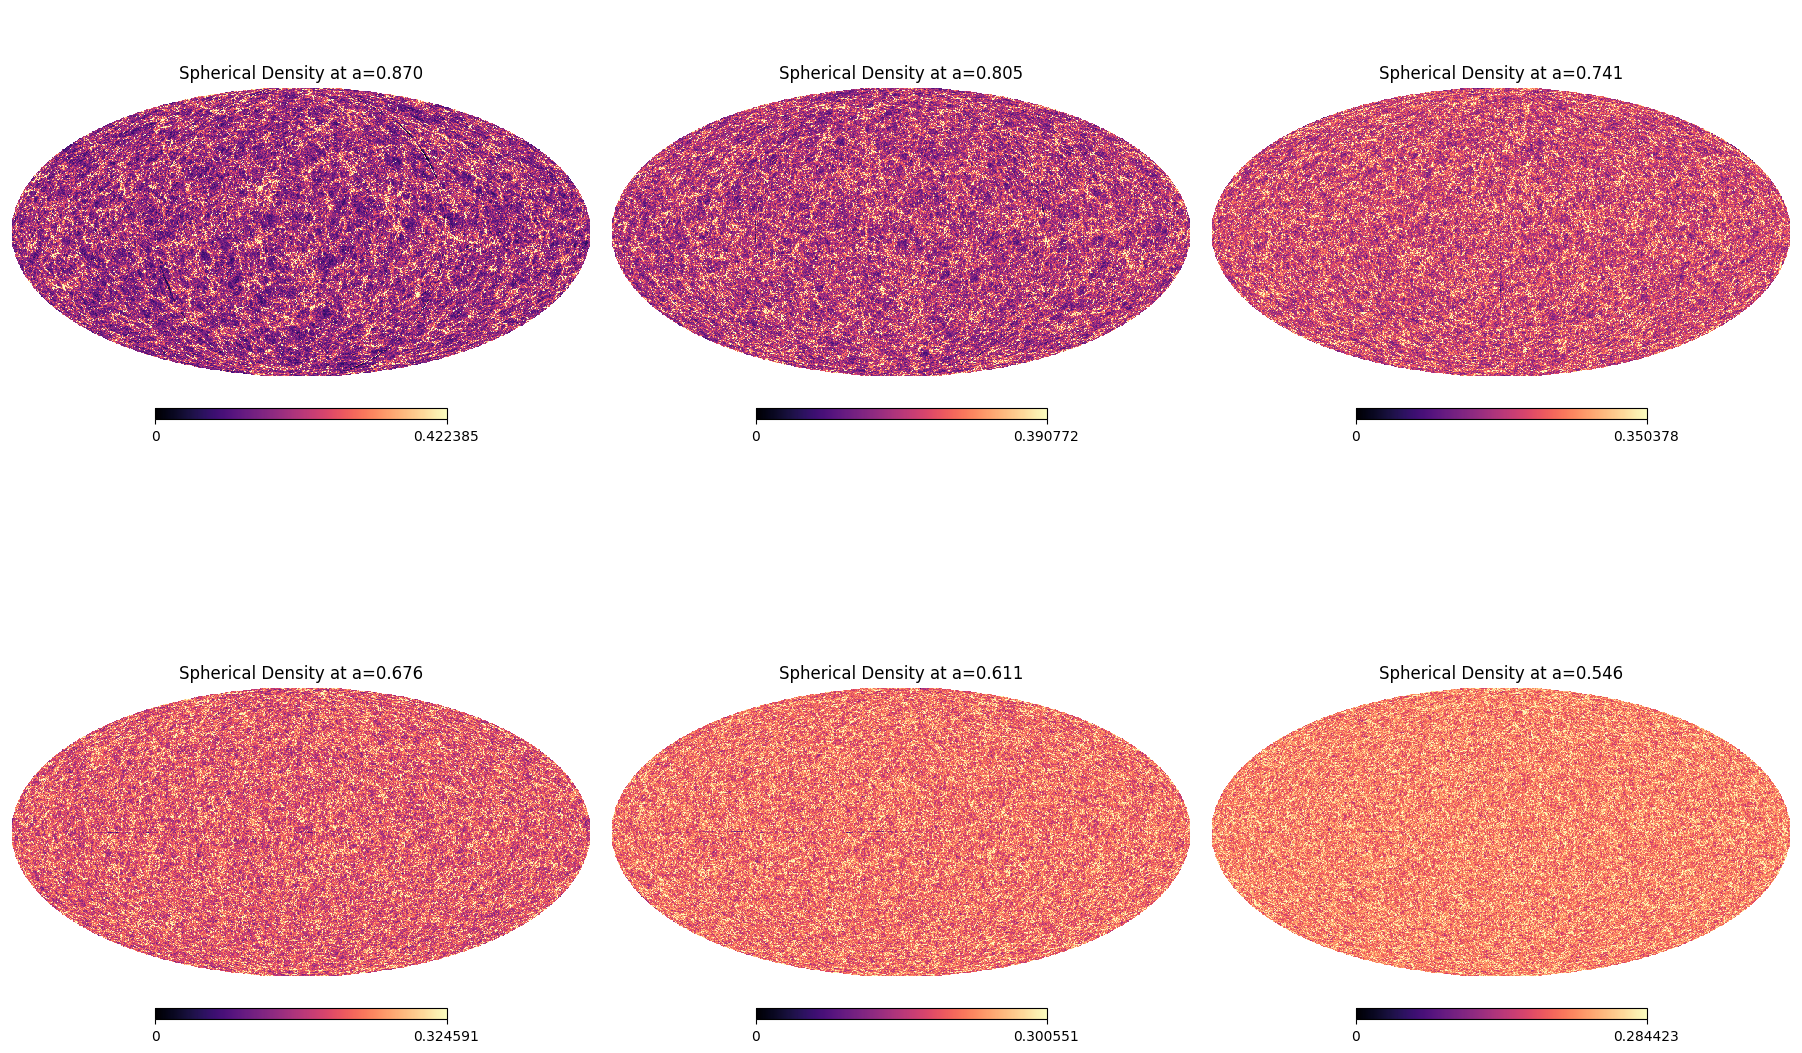

In [7]:
lightcone[-6:].show()

## Power Spectra vs Theory

Compare the measured angular power spectrum of each shell against the linear theory prediction.

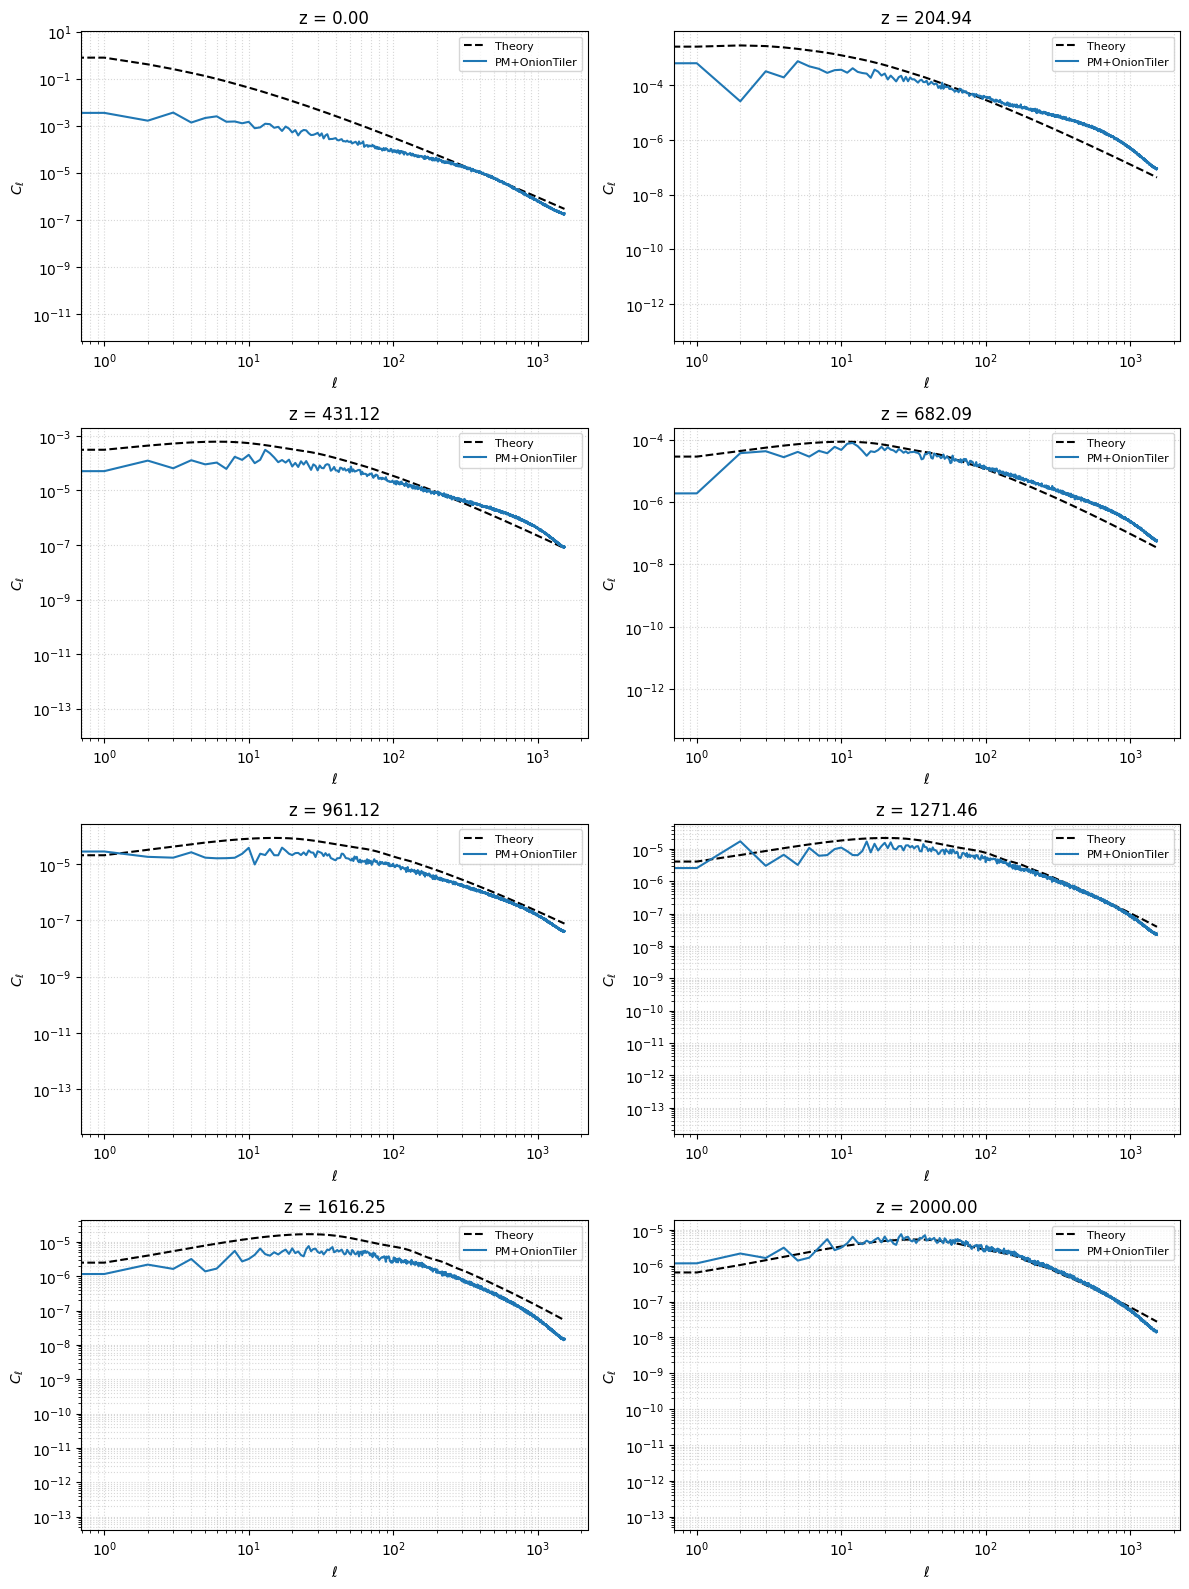

In [9]:
r_center = lightcone.comoving_centers
r_width = lightcone.density_width
r_near, r_far = r_center - r_width / 2, r_center + r_width / 2
z_near, z_far = jc.utils.a2z(jc.background.a_of_chi(cosmo, jnp.array([r_near, r_far])))

nz_s = [jfli.tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]

LMAX = 3 * nside
ells = jnp.arange(LMAX)
theory_cl = jfli.compute_theory_cl(
    cosmo,
    ell=ells,
    z_source=nz_s,
    probe_type="number_counts",
    nonlinear_fn="linear",
    cross=False,
)

# Compute measured C_ell
overdensity_lc = (lightcone / lightcone.mean(axis=1, keepdims=True)) - 1.0
cl_measured = overdensity_lc[1:].angular_cl(method="healpy")

# Plot
ncols = 2
nrows = (nb_shells + 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i in range(nb_shells):
    theory_cl[i].plot(ax=axes[i], logx=True, logy=True, label="Theory", color="black", linestyle="--")
    cl_measured[i].plot(ax=axes[i], logx=True, logy=True, label="PM+OnionTiler")
    axes[i].set_title(f"z = {float(r_center[i]):.2f}")
    axes[i].legend(fontsize=8)

for i in range(nb_shells, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()